In [1]:
from src.DeepRock.models import AdvSeg
from src.DeepRock.data import DataGenerator
from src.DeepRock.utils import split_trn_vld_tst, test_fn
import matplotlib.pyplot as plt
import numpy as np

C:\Users\yuch\Downloads\anaconda3\envs\nz_convnet\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
test_path = './data/test/'
sag_dtype = 'sent_ast_geo'
sa_dtype = 'sent_ast'
s_dtype = 'sent'

#### start to build Conv2D for different input data

In [3]:
s_conv = AdvSeg(dtype=s_dtype)
sa_conv = AdvSeg(dtype=sa_dtype)
sag_conv = AdvSeg(dtype=sag_dtype)
s_conv.build_SegmentationNet()
sa_conv.build_SegmentationNet()
sag_conv.build_SegmentationNet()

building Segmentation U-net ...
[64, 64, 64, 64]
[64, 64, 64]
compiling Segmentation only, lr is 0.001 ...
building Segmentation U-net ...
[64, 64, 64, 64]
[64, 64, 64]
compiling Segmentation only, lr is 0.001 ...
building Segmentation U-net ...
[64, 64, 64, 64]
[64, 64, 64]
compiling Segmentation only, lr is 0.001 ...


#### load weights

In [4]:
sag_conv.load_weights('./Segmentation/sent_ast_geo/weights-115-0.77.hdf5')
sa_conv.load_weights('./Segmentation/sent_ast/weights-107-0.71.hdf5')
s_conv.load_weights('./Segmentation/sent/weights-60-0.68.hdf5')

#### prepare test data

In [5]:
X_tst, Y_tst, _, _, _, _ = split_trn_vld_tst(test_path, vld_rate=0, tst_rate=0, seed=10)
s_tst_data = DataGenerator(X_tst, Y_tst, batch_size=len(X_tst), shuffle=False, dtype=s_dtype)
sa_tst_data = DataGenerator(X_tst, Y_tst, batch_size=len(X_tst), shuffle=False, dtype=sa_dtype)
sag_tst_data = DataGenerator(X_tst, Y_tst, batch_size=len(X_tst), shuffle=False, dtype=sag_dtype)

split into 238 train, 0 validation, 0 test samples


#### test

In [9]:
sa_cls = test_fn(sag_conv, sag_tst_data, plot_end=0, verbose=1)

loading test data ...
predicting with sent_ast_geo...
238/238 [==============================] - 233s 980ms/step
mean accuracy on test data is 0.32100671078978466, std is 0.1391093586877581
max is 0.932586669921875, min is 0.072906494140625


In [10]:
sa_cls

array([0.54204264, 0.8650698 , 0.94747194, 0.9991575 , 0.9962723 ,
       0.91818077, 0.95998274, 0.68219103, 0.87043333, 0.86121138])

#### calculate the accuracy

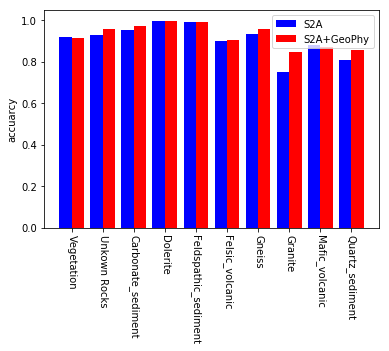

In [126]:
cls_names = ['Vegetation', 'Unkown Rocks', 'Carbonate_sediment',
           'Dolerite', 'Feldspathic_sediment', 'Felsic_volcanic', 'Gneiss', 'Granite', 'Mafic_volcanic', 'Quartz_sediment']
ax = plt.subplot(111)
ax.bar(np.arange(10)-0.2, acc_cls, width=0.4, color='b', align='center', label='S2A')
ax.bar(np.arange(10)+0.2, acc_cls_sg, width=0.4, color='r', align='center', label='S2A+GeoPhy')
plt.xticks(np.arange(10), cls_names, rotation=270)
plt.ylabel('accuarcy')
plt.legend()